In [2]:
import sys
# idk why but venv38 isn't on sys.path maybe we can fix this somehow whatever
sys.path = ['/cluster/home/bdayan/prox/venv38/lib64/python3.8/site-packages'] + sys.path


import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import math # to help with data reshaping of the data

import numpy as np
import torch
#import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# from sklearn.model_selection import train_test_split
import tqdm
import matplotlib.pyplot as plt
import logging

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
os.chdir('../')
import os.path as osp

from pose_gru import PoseGRU_inputFC2
from benji_prox_dataloader import *

numpy: 1.22.3


In [3]:
# import pyrender
# pyrender.camera

# MUJOCO_GL=osmesa

In [4]:
!module list

1h=
Currently Loaded Modules:
  1) StdEnv            4) cudnn/8.0.5        7) cuda/10.2.89
  2) gcc/8.2.0         5) nccl/2.7.8-1       8) mesa/18.3.6
  3) openblas/0.2.20   6) python_gpu/3.8.5   9) eth_proxy

 

>

In [5]:
os.environ['PYOPENGL_PLATFORM']= 'osmesa'  # our offscreen renderer will use OSMesa not Pyglet which is good as we don't have an active display manager on euler
# https://github.com/mkocabas/VIBE/issues/47 seems like maybe egl won't work
os.environ['MUJOCO_GL']= 'osmesa'

import pyrender
import PIL.Image as pil_img

W=1920
H=1080
r = pyrender.OffscreenRenderer(viewport_width=W,
                               viewport_height=H,
                               point_size=1.0)

In [6]:
# specify device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


print('-- pytorch version={}'.format(torch.__version__))
print('-- device={}'.format(device))

smplx_model_path='../models_smplx_v1_1/models/'

import smplx  # SMPL-X; pip install smplx

def get_smplx_model(gender, device):
    body_model_path = smplx_model_path
    body_model = smplx.create(body_model_path, 
                          model_type='smplx',        ## smpl, smpl+h, or smplx?
                          gender=gender, ext='npz',  ## file format 
                          num_pca_comps=12,          ## MANO hand pose pca component
                          create_global_orient=True, 
                          create_body_pose=True,
                          create_betas=True,
                          create_left_hand_pose=True,
                          create_right_hand_pose=True,
                          create_expression=True, 
                          create_jaw_pose=True,
                          create_leye_pose=True,
                          create_reye_pose=True,
                          create_transl=True,
                          batch_size=1               ## how many bodies in a batch?
                          )
    body_model.eval()
    return body_model

smplx_neutral = get_smplx_model(gender='neutral', device=device)


def draw_bodies(gender, betas, thetas):
    bm = smplx_neutral


    ## read verts and face from smplx model
    params = {'betas': betas,
              'body_pose': thetas
              }


    verts = bm(return_verts=True, **params).vertices.detach().cpu().numpy()[0]
    faces = bm.faces

    ## put verts and face into open3d, and compute surface normal
    coord = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
    body = o3d.geometry.TriangleMesh()
    body.vertices = o3d.utility.Vector3dVector(verts)
    body.triangles = o3d.utility.Vector3iVector(faces)
    body.vertex_normals = o3d.utility.Vector3dVector([])
    body.triangle_normals = o3d.utility.Vector3dVector([])
    body.compute_vertex_normals()
    o3d.visualization.draw_geometries([body, coord])
    
    return None


-- pytorch version=1.10.0+cu102
-- device=cpu


In [7]:
os.getcwd()

'/cluster/home/bdayan/prox/prox/virtual_huams_resource'

In [8]:
root_dir = '/cluster/scratch/bdayan/prox_data/PROXD_attempt2/PROXD'
root_dir3 = '/cluster/scratch/bdayan/prox_data/PROXD'
smplx_model_path='../models_smplx_v1_1/models/'
in_frames = 10
pred_frames = 5
batch_size = 15
# pd = proxDataset(root_dir, in_frames=in_frames, pred_frames=pred_frames, output_type='raw_pkls', smplx_model_path=smplx_model_path)
# pd2 = proxDataset(root_dir, in_frames=in_frames, pred_frames=pred_frames, output_type='joint_locations', smplx_model_path=smplx_model_path)

pd = proxDatasetSkeleton(output_type='raw_pkls', smplx_model_path=smplx_model_path, root_dir=root_dir, in_frames=in_frames, pred_frames=pred_frames)
pd2 = proxDatasetSkeleton(output_type='raw_pkls', smplx_model_path=smplx_model_path, root_dir=root_dir3, in_frames=in_frames, pred_frames=pred_frames)

root_dir2 = '/cluster/scratch/bdayan/prox_data/recordings'
bd = DatasetBase(root_dir=root_dir2, search_prefix='Color', extra_prefix='')


dataloader = DataLoader(pd, batch_size=1,
                        shuffle=True, num_workers=0, collate_fn=my_collate)


In [9]:
len(pd.sequences), len(bd.sequences), len(pd2.sequences)

(54, 60, 54)

In [10]:
areas = [thing[0] for thing in pd.sequences]
bd.sequences = [x for x in bd.sequences if x[0] in areas]

seq_lens = [len(fns_dict) for stem, fns_dict in bd.sequences]
bd.bounds = np.array([seq_len // bd.tot_frames for seq_len in seq_lens])  # e.g. 
assert(np.all(bd.bounds >= 1)), "sequence has insufficient frames for one training input"  # sanity check
bd.bounds = np.cumsum(bd.bounds)

In [11]:
len(bd), len(pd), len(pd2)

(5902, 5876, 5876)

In [12]:
import tqdm
for i in tqdm.tqdm(range(150, 200)):
    a = bd.__getitem__(i)
    b = pd.__getitem__(i)
    p1 = Path(a[0][0]['fn']).stem
    p2 = Path(b[1][0][0]).parent.name
    if p1 != p2:
        print(i)
        break

  8%|▊         | 4/50 [00:00<00:03, 15.05it/s]

154


In [13]:
i = 153
a = bd.__getitem__(i)
b = pd.__getitem__(i)

a[1]
a[3]
b[1][0]
b[2][0]

['/cluster/scratch/bdayan/prox_data/recordings/MPH112_03515_01/Color/s001_frame_00286__00.00.09.503.jpg',
 '/cluster/scratch/bdayan/prox_data/recordings/MPH112_03515_01/Color/s001_frame_00287__00.00.09.536.jpg',
 '/cluster/scratch/bdayan/prox_data/recordings/MPH112_03515_01/Color/s001_frame_00288__00.00.09.571.jpg',
 '/cluster/scratch/bdayan/prox_data/recordings/MPH112_03515_01/Color/s001_frame_00289__00.00.09.603.jpg',
 '/cluster/scratch/bdayan/prox_data/recordings/MPH112_03515_01/Color/s001_frame_00290__00.00.09.637.jpg',
 '/cluster/scratch/bdayan/prox_data/recordings/MPH112_03515_01/Color/s001_frame_00291__00.00.09.671.jpg',
 '/cluster/scratch/bdayan/prox_data/recordings/MPH112_03515_01/Color/s001_frame_00292__00.00.09.703.jpg',
 '/cluster/scratch/bdayan/prox_data/recordings/MPH112_03515_01/Color/s001_frame_00293__00.00.09.737.jpg',
 '/cluster/scratch/bdayan/prox_data/recordings/MPH112_03515_01/Color/s001_frame_00294__00.00.09.769.jpg',
 '/cluster/scratch/bdayan/prox_data/recordings

['/cluster/scratch/bdayan/prox_data/recordings/MPH112_03515_01/Color/s001_frame_00296__00.00.09.837.jpg',
 '/cluster/scratch/bdayan/prox_data/recordings/MPH112_03515_01/Color/s001_frame_00297__00.00.09.869.jpg',
 '/cluster/scratch/bdayan/prox_data/recordings/MPH112_03515_01/Color/s001_frame_00298__00.00.09.903.jpg',
 '/cluster/scratch/bdayan/prox_data/recordings/MPH112_03515_01/Color/s001_frame_00299__00.00.09.936.jpg',
 '/cluster/scratch/bdayan/prox_data/recordings/MPH112_03515_01/Color/s001_frame_00300__00.00.09.971.jpg']

['/cluster/scratch/bdayan/prox_data/PROXD_attempt2/PROXD/MPH112_03515_01/results/s001_frame_00286__00.00.09.503/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD_attempt2/PROXD/MPH112_03515_01/results/s001_frame_00287__00.00.09.536/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD_attempt2/PROXD/MPH112_03515_01/results/s001_frame_00288__00.00.09.571/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD_attempt2/PROXD/MPH112_03515_01/results/s001_frame_00289__00.00.09.603/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD_attempt2/PROXD/MPH112_03515_01/results/s001_frame_00290__00.00.09.637/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD_attempt2/PROXD/MPH112_03515_01/results/s001_frame_00291__00.00.09.671/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD_attempt2/PROXD/MPH112_03515_01/results/s001_frame_00292__00.00.09.703/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD_attempt2/PROXD/MPH112_03515_01/results/s001_frame_00293__00.00.09.737/000.pkl',
 '/cluster/scratch/bdaya

['/cluster/scratch/bdayan/prox_data/PROXD_attempt2/PROXD/MPH112_03515_01/results/s001_frame_00296__00.00.09.837/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD_attempt2/PROXD/MPH112_03515_01/results/s001_frame_00297__00.00.09.869/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD_attempt2/PROXD/MPH112_03515_01/results/s001_frame_00298__00.00.09.903/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD_attempt2/PROXD/MPH112_03515_01/results/s001_frame_00380__00.00.12.637/000.pkl',
 '/cluster/scratch/bdayan/prox_data/PROXD_attempt2/PROXD/MPH112_03515_01/results/s001_frame_00381__00.00.12.670/000.pkl']

In [12]:
a, b = bd.__getitem__(100), pd.__getitem__(100)

In [13]:
from matplotlib import image
image = image.imread(a[1][0])

(1080, 1920, 3)

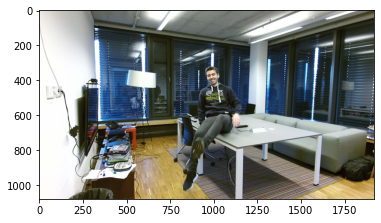

In [14]:
plt.imshow(image)
image.shape

In [15]:
_, in_data, pred_data = pd.__getitem__(100)

In [16]:
joint_locations = []
vertices = []
for data in in_data[1]:
    betas = torch.Tensor(data['betas'])
    body_pose = torch.Tensor(data['body_pose'])
    global_orient= torch.Tensor(data['global_orient'])
    transl=torch.Tensor(data['transl'])
    out = smplx_neutral(return_joints=True, betas=betas, body_pose=body_pose, global_orient=global_orient, transl=transl)
    joints = out.joints[:, :25].squeeze()
    joint_locations.append(joints)
    vertices.append(out.vertices.detach().cpu().numpy().squeeze())

In [68]:
vertices[0], smplx_neutral.faces

(array([[-0.00816492, -0.32928956,  2.7343996 ],
        [-0.00436806, -0.3272729 ,  2.7343545 ],
        [-0.00384088, -0.3267575 ,  2.7345965 ],
        ...,
        [-0.09002069, -0.36297035,  2.6528718 ],
        [-0.08799845, -0.36329764,  2.6542685 ],
        [-0.08573306, -0.36347234,  2.6552746 ]], dtype=float32),
 array([[    3,     1,     0],
        [    7,     5,     4],
        [   12,    14,    13],
        ...,
        [ 9944, 10097, 10084],
        [ 9940, 10084, 10071],
        [10071, 10058,  9932]], dtype=uint32))

In [17]:
vertices[0].shape

(10475, 3)

In [18]:
smplx_neutral.faces

array([[    3,     1,     0],
       [    7,     5,     4],
       [   12,    14,    13],
       ...,
       [ 9944, 10097, 10084],
       [ 9940, 10084, 10071],
       [10071, 10058,  9932]], dtype=uint32)

In [19]:
import trimesh
out_mesh = trimesh.Trimesh(vertices[0], smplx_neutral.faces, process=False)

In [20]:
image.shape

(1080, 1920, 3)

In [22]:
out_img_fn = 'temp_outfn'

In [24]:
img.shape

(1080, 1920, 3)

In [25]:
color.shape

(1080, 1920, 3)

In [26]:
valid_mask.shape

(1080, 1920, 1)

In [27]:
_.shape

(1080, 1920)

In [32]:
color, depth = r.render(scene)
color.shape, depth.shape

color, depth = r.render(scene, flags=pyrender.RenderFlags.RGBA)
color.shape, depth.shape

((1080, 1920, 3), (1080, 1920))

((1080, 1920, 3), (1080, 1920))

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

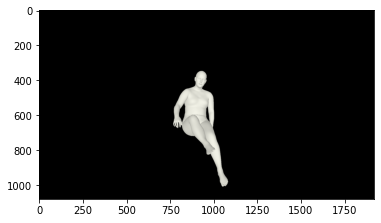

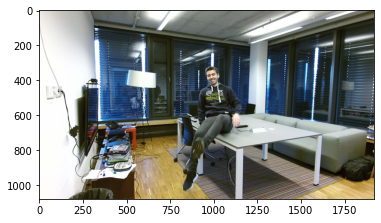

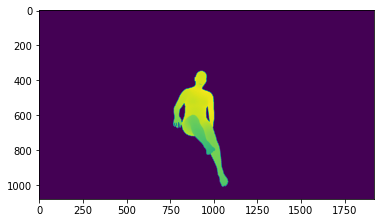

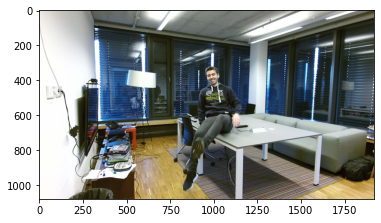

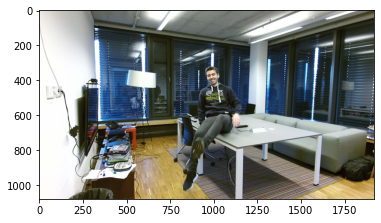

In [52]:
plt.imshow(color)
plt.figure()
plt.imshow(image)
plt.figure()
plt.imshow(depth)
plt.figure()
plt.imshow(torch.tensor(image))
plt.figure()
plt.imshow(torch.tensor(image).detach().cpu().numpy())

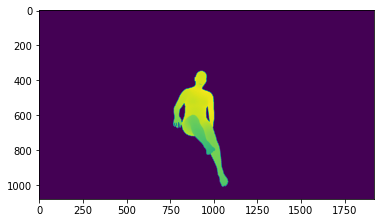

In [30]:
plt.imshow(depth)

In [64]:
np.max(color)
np.max(image)
np.max(input_img)
np.max(output_img)

0.9490196

255

255

255.0

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

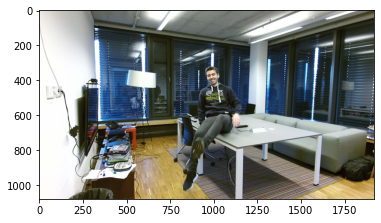

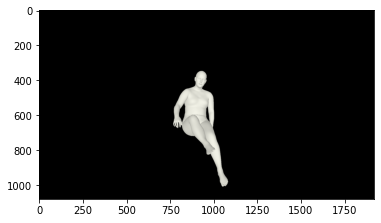

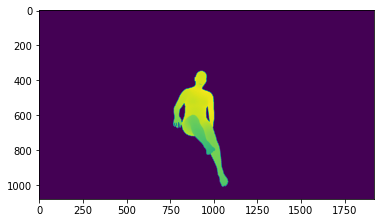

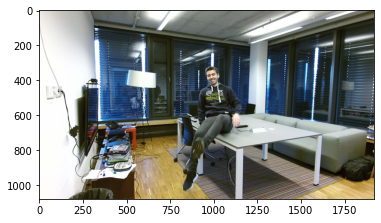

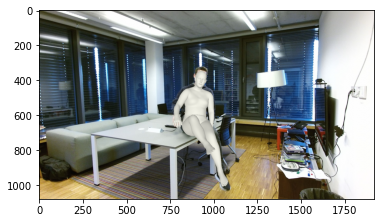

In [66]:

img = torch.tensor(image)
out_img_fn = 'temp_out.png'

# common
H, W = 1080, 1920
camera_center = np.array([951.30, 536.77])
camera_pose = np.eye(4)
camera_pose = np.array([1.0, -1.0, -1.0, 1.0]).reshape(-1, 1) * camera_pose
camera = pyrender.camera.IntrinsicsCamera(
    fx=1060.53, fy=1060.38,
    cx=camera_center[0], cy=camera_center[1])
light = pyrender.DirectionalLight(color=np.ones(3), intensity=2.0)

material = pyrender.MetallicRoughnessMaterial(
    metallicFactor=0.0,
    alphaMode='OPAQUE',
    baseColorFactor=(1.0, 1.0, 0.9, 1.0))
body_mesh = pyrender.Mesh.from_trimesh(
    out_mesh, material=material)

## rendering body

img = img.detach().cpu().numpy()
H, W, _ = img.shape

scene = pyrender.Scene(bg_color=[0.0, 0.0, 0.0, 0.0],
                       ambient_light=(0.3, 0.3, 0.3))
scene.add(camera, pose=camera_pose)
scene.add(light, pose=camera_pose)
# for node in light_nodes:
#     scene.add_node(node)

scene.add(body_mesh, 'mesh')

r = pyrender.OffscreenRenderer(viewport_width=W,
                               viewport_height=H,
                               point_size=1.0)
color, depth = r.render(scene, flags=pyrender.RenderFlags.RGBA)
color = color.astype(np.float32)  / 255.0

# valid_mask = (color[:, :, -1] > 0)[:, :, np.newaxis]
# input_img = img
# output_img = (color[:, :, :-1] * valid_mask +
#               (1 - valid_mask) * input_img)

valid_mask = (color > 0)
input_img = img
output_img = (color * valid_mask + (1-valid_mask)*np.flip(input_img, axis=1)/255.0)


plt.imshow(image)
plt.figure()
plt.imshow(color)
plt.figure()
plt.imshow(depth)
plt.figure()
plt.imshow(torch.tensor(image))
plt.figure()
plt.imshow(torch.tensor(image).detach().cpu().numpy())
plt.imshow(output_img)


output_img2 = pil_img.fromarray((output_img * 255).astype(np.uint8))
output_img2.save(out_img_fn)

##redering body+scene
body_mesh = pyrender.Mesh.from_trimesh(
    out_mesh, material=material)
static_scene = trimesh.load(osp.join(scene_dir, scene_name + '.ply'))
trans = np.linalg.inv(cam2world)
static_scene.apply_transform(trans)

static_scene_mesh = pyrender.Mesh.from_trimesh(
    static_scene)

scene = pyrender.Scene()
scene.add(camera, pose=camera_pose)
scene.add(light, pose=camera_pose)

scene.add(static_scene_mesh, 'mesh')
scene.add(body_mesh, 'mesh')

r = pyrender.OffscreenRenderer(viewport_width=W,
                               viewport_height=H)
color, _ = r.render(scene)
color = color.astype(np.float32) / 255.0
img = pil_img.fromarray((color * 255).astype(np.uint8))
# img.save(body_scene_rendering_fn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

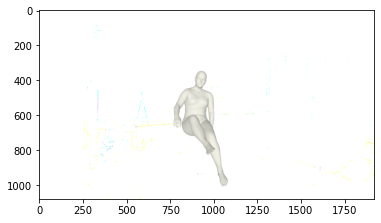

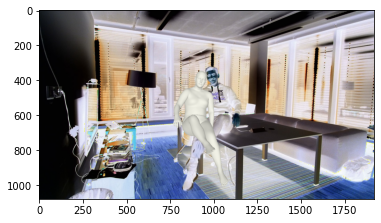

In [45]:
plt.imshow(output_img)
plt.figure()
plt.imshow(img)

In [37]:
img.shape
input_img.shape
color*valid_mask

(1080, 1920, 3)

(1080, 1920, 3)

ValueError: operands could not be broadcast together with shapes (1080,1920,3) (1080,1920,1,3) 

In [ ]:
plt.imshow(image)

In [ ]:
point_cloud_batch = Pointclouds(points=[points, points + 2], features=[rgb, torch.zeros_like(rgb)])
# render both in the same plot in different traces
fig = plot_scene({
    "Pointcloud": {
        "person": point_cloud_batch[0],
        "person2": point_cloud_batch[1]
    }
})
fig.update_layout(autosize=False,width=800,height=800)
fig.show()

In [ ]:
R

In [ ]:
T

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread('/cluster/scratch/bdayan/prox_data/recordings/N3OpenArea_00158_01/Color/s001_frame_00076__00.00.02.509.jpg')

In [ ]:
img.shape

In [ ]:
images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].detach().numpy())
plt.axis("off");

In [27]:
len(in_data[1])

10

In [28]:
g1 = in_data[1][0]['global_orient']
g2 = in_data[1][1]['global_orient']

In [58]:
g1
g2
from pytorch3d import transforms

array([[ 1.1642715, -0.5064939,  2.978201 ]], dtype=float32)

array([[ 1.242714 , -0.5080164,  2.951133 ]], dtype=float32)

In [67]:

# r1 = o3d.geometry.Geometry3D.get_rotation_matrix_from_xyz(g1.reshape(3, 1))
# r2 = o3d.geometry.Geometry3D.get_rotation_matrix_from_xyz(g2.reshape(3, 1))

r1 = transforms.euler_angles_to_matrix(torch.Tensor(g1), convention='XYZ')
r2 = transforms.euler_angles_to_matrix(torch.Tensor(g2), convention='XYZ')


In [72]:
g1

array([[ 1.1642715, -0.5064939,  2.978201 ]], dtype=float32)

In [69]:
r1.shape
r1.transpose(1, 2) @ r1

torch.Size([1, 3, 3])

tensor([[[1.0000e+00, 0.0000e+00, 2.8871e-08],
         [0.0000e+00, 1.0000e+00, 0.0000e+00],
         [2.8871e-08, 0.0000e+00, 1.0000e+00]]])

In [71]:
transforms.matrix_to_euler_angles(r2 @ r1.transpose(1, 2), convention='XYZ')

tensor([[ 0.0917,  0.0211, -0.0109]])

In [73]:
transforms.matrix_to_euler_angles(r1 @ r1.transpose(1, 2), convention='XYZ')

tensor([[-0.0000e+00, -1.4901e-08, -2.9802e-08]])

In [29]:
outs

[tensor([[[-0.4150,  0.2488,  2.5232],
          [-0.4491,  0.3484,  2.4745],
          [-0.3576,  0.3540,  2.5615],
          [-0.3891,  0.1443,  2.4939],
          [-0.5949,  0.6758,  2.5726],
          [-0.3504,  0.7028,  2.6339],
          [-0.4023,  0.0097,  2.4948],
          [-0.6543,  1.0304,  2.7177],
          [-0.3213,  1.0933,  2.6417],
          [-0.4136, -0.0404,  2.5236],
          [-0.7405,  1.0668,  2.8116],
          [-0.3948,  1.1626,  2.7245],
          [-0.3898, -0.2098,  2.5113],
          [-0.4429, -0.1261,  2.4899],
          [-0.3750, -0.1269,  2.5450],
          [-0.4740, -0.3604,  2.5355],
          [-0.5185, -0.1981,  2.4248],
          [-0.3228, -0.1933,  2.6111],
          [-0.4975,  0.0453,  2.3447],
          [-0.2574,  0.0575,  2.6541],
          [-0.5567,  0.2695,  2.3911],
          [-0.2741,  0.2773,  2.7326],
          [-0.4599, -0.3616,  2.5398],
          [-0.5337, -0.3930,  2.5738],
          [-0.4865, -0.3970,  2.6115]]], grad_fn=<SliceBackward0

In [39]:
joined = np.concatenate([outs[0], outs[1]], axis=0)

In [31]:
dir(o3d)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [30]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(joined)
o3d.visualization.draw_geometries([pcd])

AttributeError: module 'open3d' has no attribute 'geometry'

In [ ]:
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

In [32]:
import pytorch3d

In [2]:
joints

NameError: name 'joints' is not defined

In [ ]:
gender = 'neutral'
betas = torch.FloatTensor(1,10).zero_()
# thetas = vposer.decode(torch.FloatTensor(1,32).normal_(), output_type='aa')
thetas = torch.FloatTensor(1, 21, 3).zero_()

draw_bodies(gender, betas, thetas)

In [116]:
p = Path(r'D:\prox_data\joint_locations\BasementSittingBooth_00142_01\results\s001_frame_00010__00.00.00.305\000.pkl')
with open(r'D:\prox_data\joint_locations\BasementSittingBooth_00142_01\results\s001_frame_00010__00.00.00.305\000.pkl', 'rb') as file:
    temp = pickle.load(file)

In [126]:
a, b = temp['in_joint_locations'], temp['pred_joint_locations']
a[0]
a.shape
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.concatenate([a[-2].detach().numpy(), a[-1].detach().numpy()], axis=0))
o3d.visualization.draw_geometries([pcd])

tensor([[-0.0793, -0.3643, -0.0065],
        [ 0.0019, -0.4264, -0.0635],
        [-0.1156, -0.4719, -0.0657],
        [-0.1137, -0.2532,  0.0073],
        [ 0.1609, -0.7483, -0.1987],
        [-0.0530, -0.7553, -0.2893],
        [-0.1397, -0.1278,  0.0670],
        [ 0.1915, -1.1004, -0.3962],
        [ 0.0693, -1.0991, -0.4749],
        [-0.1601, -0.0900,  0.1138],
        [ 0.2967, -1.1270, -0.3082],
        [-0.0264, -1.1608, -0.3975],
        [-0.2185,  0.0698,  0.1510],
        [-0.1376,  0.0035,  0.1413],
        [-0.2303, -0.0212,  0.1363],
        [-0.1946,  0.2015,  0.2573],
        [-0.0353,  0.0929,  0.1427],
        [-0.3464, -0.0016,  0.1509],
        [ 0.0479, -0.1223,  0.0087],
        [-0.3563, -0.2643,  0.0736],
        [ 0.1711, -0.3284, -0.0585],
        [-0.3611, -0.5015,  0.0078],
        [-0.2103,  0.1975,  0.2599],
        [-0.1480,  0.2287,  0.3171],
        [-0.1990,  0.2080,  0.3455]], grad_fn=<SelectBackward0>)

torch.Size([10, 25, 3])

In [108]:
from pathlib import PurePath
PurePath(p)

PureWindowsPath('D:/prox_data/PROXD_attempt2/PROXD/../../joint_locations/BasementSittingBooth_00142_01\results/s001_frame_00010__00.00.00.305\x00.pkl')

In [110]:
'asdf'.replace('s', 'a')

'aadf'